# (10주차) 11월3일 
> 순환신경망-- AbAcAd예제(2) 

- toc:true
- branch: master
- badges: true
- comments: true
- author: 최규빈

## import

In [13]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time 

## Define some funtions

In [2]:
def f(txt,mapping):
    return [mapping[key] for key in txt] 
soft = torch.nn.Softmax(dim=1)

## 예비학습: `net.parameters()`의 의미 

9월27일 강의노트 중 "`net.parameters()`의 의미?"를 설명한다. 

`-` iterator, generator의 개념필요 
- https://guebin.github.io/IP2022/2022/06/06/(14주차)-6월6일.html, 클래스공부 8단계 참고 


`-` 탐구시작: 네트워크 생성 

In [31]:
net = torch.nn.Linear(in_features=1,out_features=1)
net.weight

Parameter containing:
tensor([[0.7914]], requires_grad=True)

In [32]:
net.bias

Parameter containing:
tensor([-0.7958], requires_grad=True)

`-` torch.optim.SGD? 를 확인하면 params에 대한설명에 아래와 같이 되어있음 

```
params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
```

`-` 설명을 읽어보면 params에 iterable object를 넣으라고 되어있음 (iterable object는 숨겨진 명령어로 `__iter__`를 가지고 있는 오브젝트를 의미)

In [33]:
set(dir(net.parameters)) & {'__iter__'}

set()

In [34]:
set(dir(net.parameters())) & {'__iter__'}

{'__iter__'}

`-` 무슨의미? 

In [35]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[0.7914]], requires_grad=True)
Parameter containing:
tensor([-0.7958], requires_grad=True)


`-` 그냥 이건 이런느낌인데? 

In [36]:
for param in [net.weight,net.bias]:
    print(param)

Parameter containing:
tensor([[0.7914]], requires_grad=True)
Parameter containing:
tensor([-0.7958], requires_grad=True)


결론: `net.parameters()`는 net오브젝트에서 학습할 파라메터를 모두 모아 리스트(iterable object)로 만드는 함수라 이해할 수 있다. 

`-` 응용예제1

In [37]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-09-22-regression.csv") 
x=torch.tensor(df.x).float().reshape(100,1)
y=torch.tensor(df.y).float().reshape(100,1)
_1 = torch.ones([100,1])
X = torch.concat([_1,x],axis=1)

In [38]:
b = torch.tensor(-5.0,requires_grad=True)
w = torch.tensor(10.0,requires_grad=True)
optimizr = torch.optim.SGD([b,w],lr=1/10) ## 이렇게 전달하면 됩니당!!

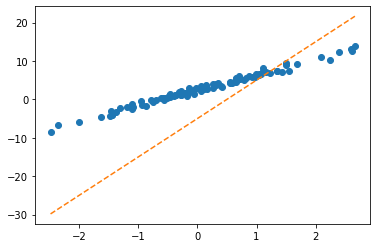

In [39]:
plt.plot(x,y,'o')
plt.plot(x,(w*x+b).data,'--')

In [40]:
for epoc in range(30):
    yhat = b+ w*x 
    loss = torch.mean((y-yhat)**2)
    loss.backward()
    optimizr.step(); optimizr.zero_grad()

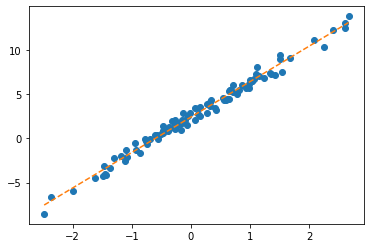

In [41]:
plt.plot(x,y,'o')
plt.plot(x,(w*x+b).data,'--')

`-` 응용예제2

In [42]:
What = torch.tensor([[-5.0],[10.0]],requires_grad=True)
optimizr = torch.optim.SGD([What],lr=1/10) # What은 iterable 하지 않지만 [What]은 iterable 함

In [43]:
What

tensor([[-5.],
        [10.]], requires_grad=True)

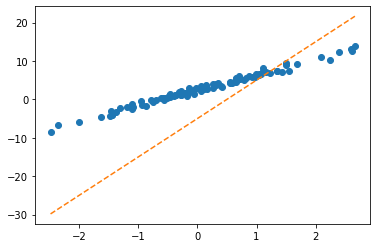

In [44]:
plt.plot(x,y,'o')
plt.plot(x,(X@What).data,'--')

In [45]:
for epoc in range(30):
    yhat = X@What 
    loss = torch.mean((y-yhat)**2)
    loss.backward()
    optimizr.step();optimizr.zero_grad() 

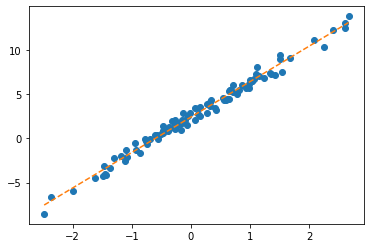

In [46]:
plt.plot(x,y,'o')
plt.plot(x,(X@What).data,'--')

## Exam4: AbAcAd

### data

`-` 기존의 정리방식

In [48]:
txt = list('AbAcAd')*100
txt[:10]

['A', 'b', 'A', 'c', 'A', 'd', 'A', 'b', 'A', 'c']

In [49]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [50]:
txt_x[:5],txt_y[:5]

(['A', 'b', 'A', 'c', 'A'], ['b', 'A', 'c', 'A', 'd'])

In [51]:
x = torch.tensor(f(txt_x,{'A':0,'b':1,'c':2,'d':3}))
y = torch.tensor(f(txt_y,{'A':0,'b':1,'c':2,'d':3}))

In [54]:
x[:8],y[:8]

(tensor([0, 1, 0, 2, 0, 3, 0, 1]), tensor([1, 0, 2, 0, 3, 0, 1, 0]))

`-` 이번엔 원핫인코딩형태까지 미리 정리하자. (임베딩 레이어 안쓸예정)

### 실패했던 풀이: 구현1

`-` 저번시간의 실패한 풀이 

`-` Tanh까지만 클래스로 바꾸어서 구현 
- 클래스를 이용하는 방법: https://guebin.github.io/DL2022/2022/11/01/(9주차)-11월1일.html#로지스틱-모형을-이용한-풀이

`-` for문돌릴준비

`-` for문: 20회반복

`-` linr(hnet(x)) 적합결과 <-- 숫자체크

### 실패했던 풀이: 구현2

`-` Tanh까지 구현한 클래스

`-` for문돌릴준비 

`-` for문: 20회 반복

`-` linr(hnet(x)) 적합결과 <-- 숫자체크

### 순환신경망의 아이디어

#### ***모티브***

***(예비생각1) ${\boldsymbol h}$에 대한 이해***

${\boldsymbol h}$는 사실 문자열 'abcd'들을 숫자로 바꾼 또 다른 형식의 숫자표현이라 해석할 수 있음. 즉 원핫인코딩과 다른 또 다른 형태의 숫자표현이라 해석할 수 있다. (사실 원핫인코딩보다 약간 더 (1) 액기스만 남은 느낌 + (2) 숙성된 느낌을 준다) 
- (why1) h는 "학습을 용이하게 하기 위해서 x를 적당히 선형적으로 전처리한 상태"라고 이해가능
- (why2) 실제로 예시를 살펴보면 그러했다. 

결론: 사실 ${\boldsymbol h}$는 잘 숙성되어있는 입력정보 ${\bf X}$ 그 자체로 해석 할 수 있다. 

***(예비생각2) [수백년전통을 이어가는 방법](https://www.joongang.co.kr/article/24087690#home)***

```
“1리터에 500만원에 낙찰된 적 있습니다.”
“2kg에 1억원 정도 추산됩니다.”
“20여 종 종자장을 블렌딩해 100ml에 5000만원씩 분양 예정입니다.”

모두 씨간장(종자장) 가격에 관한 실제 일화다.

(중략...)

위스키나 와인처럼 블렌딩을 하기도 한다. 
새로 담근 간장에 씨간장을 넣거나, 씨간장독에 햇간장을 넣어 맛을 유지하기도 한다. 
이를 겹장(또는 덧장)이라 한다. 
몇몇 종갓집에선 씨간장 잇기를 몇백 년째 해오고 있다. 
매년 새로 간장을 담가야 이어갈 수 있으니 불씨 꺼트리지 않는 것처럼 굉장히 어려운 일이다.
이렇게 하는 이유는 집집마다 내려오는 고유 장맛을 잃지 않기 위함이다. 
씨간장이란 그만큼 소중한 주방의 자산이며 정체성이다.
```

덧장: 새로운간장을 만들때, 옛날간장을 섞어서 만듬 

`*` 기존방식
- $\text{콩물} \overset{\text{숙성}}{\longrightarrow} \text{간장}$

`*` 수백년 전통의 간장맛을 유지하는 방식

- $\text{콩물}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1$
- $\text{콩물}_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2$
- $\text{콩물}_3, \text{간장}_2 \overset{\text{숙성}}{\longrightarrow} \text{간장}_3$

`*` 수백년 전통의 간장맛을 유지하면서 조리를 한다면? 

- $\text{콩물}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_1$
- $\text{콩물}_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_2$
- $\text{콩물}_3, \text{간장}_2 \overset{\text{숙성}}{\longrightarrow} \text{간장}_3 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_3$

점점 맛있는 간장계란밥이 탄생함 

`*` 알고리즘의 편의상 아래와 같이 생각해도 무방 

- $\text{콩물}_1, \text{간장}_0 \overset{\text{숙성}}{\longrightarrow} \text{간장}_1 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_1$, $\text{간장}_0=\text{맹물}$
- $\text{콩물}_2, \text{간장}_1 \overset{\text{숙성}}{\longrightarrow} \text{간장}_2 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_2$
- $\text{콩물}_3, \text{간장}_2 \overset{\text{숙성}}{\longrightarrow} \text{간장}_3 \overset{\text{조리}}{\longrightarrow} \text{간장계란밥}_3$

***아이디어***

`*` 수백년 전통의 간장맛을 유지하면서 조리하는 과정을 수식으로? 

- $\boldsymbol{x}_1, \boldsymbol{h}_0 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_1 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_1$
- $\boldsymbol{x}_2, \boldsymbol{h}_1 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_2 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_2$
- $\boldsymbol{x}_3, \boldsymbol{h}_2 \overset{\text{숙성}}{\longrightarrow} \boldsymbol{h}_3 \overset{\text{조리}}{\longrightarrow} \hat{\boldsymbol y}_3$

이제 우리가 배울것은 (1) "$\text{콩물}_{t}$"와 "$\text{간장}_{t-1}$"로 "$\text{간장}_t$"를 `숙성`하는 방법 (2) "$\text{간장}_t$"로 "$\text{간장계란밥}_t$를 `조리`하는 방법이다 

즉 `숙성`담당 네트워크와 `조리`담당 네트워크를 각각 만들어 학습하면 된다. 

#### ***기존구조***

#### ***바뀌는 구조***

(1) $t=0$

${\boldsymbol h}_0=[[0,0]]$ <-- $\text{간장}_0$은 맹물로 초기화

---

(2) $t=1$ 

${\boldsymbol h}_1= \tanh({\boldsymbol x}_1{\bf W}_{ih}+{\boldsymbol h}_0{\bf W}_{hh}+{\boldsymbol b}_{ih}+{\boldsymbol b}_{hh})$
- ${\boldsymbol x}_1$: (1,4) 
- ${\bf W}_{ih}$: (4,2) 
- ${\boldsymbol h}_0$: (1,2) 
- ${\bf W}_{hh}$: (2,2) 
- ${\boldsymbol b}_{ih}$: (1,2)
- ${\boldsymbol b}_{hh}$: (1,2)

${\boldsymbol o}_1= {\bf W}_{ho}{\boldsymbol h}_1+{\boldsymbol b}_{ho}$

$\hat{\boldsymbol y}_1 = \text{soft}({\boldsymbol o}_1)$

---

일반화된 알고리즘 

***(ver1)***

init $\boldsymbol{h}_0$ 

for $t$ in $1:T$ 

- ${\boldsymbol h}_t= \tanh({\boldsymbol x}_t{\bf W}_{ih}+{\boldsymbol h}_{t-1}{\bf W}_{hh}+{\boldsymbol b}_{ih}+{\boldsymbol b}_{hh})$
- ${\boldsymbol o}_t= {\bf W}_{ho}{\boldsymbol h}_1+{\boldsymbol b}_{ho}$
- $\hat{\boldsymbol y}_t = \text{soft}({\boldsymbol o}_1)$
    

***(ver2)***

```Python 
init hidden

for t in 1:T 
    hidden = tanh(linr(x)+linr(hidden))
    output = linr(hidden)
    yt_hat = soft(output)
```    

- 코드상으로는 $h_t$와 $h_{t-1}$의 구분이 교모하게 사라진다. (그래서 오히려 좋아)

---

***전체알고리즘은 대충 아래와 같은 형식으로 구현될 수 있음***

```Python 
### 
class rNNCell(torch.nn.Module):
    def __init__(self):
        super().__init__()
        linr1 = torch.nn.Linear(?,?) 
        linr2 = torch.nn.Linear(?,?) 
        tanh = torch.nn.Tanh()
    def forward(self,hidden,x):
        hidden = tanh(lrnr1(x)+lrnr2(hidden))
        return hidden

init ht
rnncell = rNNCell()

for t in 1:T 
    xt, yt = x[[t]], y[[t]] 
    ht = rnncell(xt, ht)
    ot = linr(ht) 
    loss = loss + loss_fn(ot, yt)

```    

### 순환신경망 구현1 -- 성공 

`(1)` 숙성담당 네트워크

`(2)` 조리담당 네트워크

`(3)` 손실함수, 옵티마이저 설계 

`(4)` 학습 (6분정도 걸림)

`(5)` 시각화 

- 아주 특이한 특징: yhat[:15], yhat[:-15] 의 적합결과가 다르다
- 왜? 간장계란밥은 간장이 중요한데, 간장은 시간이 갈수록 맛있어지니까..

### 순환신경망 구현2 (with RNNCell) -- 성공 

ref: https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html

`(1)` 숙성네트워크

선언

가중치초기화

`(2)` 조리네트워크

`(3)` 손실함수와 옵티마이저 

`(4)` 학습

`(5)` 시각화 

### 순환신경망 구현3 (with RNN) -- 성공 

---

(예비학습)

`-` 아무리 생각해도 yhat구하려면 좀 귀찮음

`-` 이렇게 하면 쉽게(?) 구할 수 있음 

- 똑같음!

`-` rnn(x,_water)의 결과는 (1) 599년치 간장 (2) 599번째 간장 이다 

In [39]:
rnn(x,_water)

(tensor([[-0.2232,  0.9769],
         [-0.9999, -0.9742],
         [ 0.9154,  0.9992],
         ...,
         [ 0.9200,  0.9992],
         [-0.9978, -0.0823],
         [-0.9154,  0.9965]], grad_fn=<SqueezeBackward1>),
 tensor([[-0.9154,  0.9965]], grad_fn=<SqueezeBackward1>))

***(예비학습결론) torch.nn.RNN(4,2)는 torch.nn.RNNCell(4,2)의 batch 버전이다. (for문이 포함된 버전이다)***

---

torch.nn.RNN(4,2)를 이용하여 구현하자. 

`(1)` 숙성네트워크

선언

가중치초기화

`(2)` 조리네트워크

`(3)` 손실함수와 옵티마이저

`(4)` 학습

`(5)` 시각화